# Fashion MNIST CNN 모델링 및 평가
Keras를 사용하여 Fashion MNIST 데이터셋을 합성곱 신경망(CNN) 구조로 모델링하고 평가합니다.

## 1. 패키지 로드 및 설정

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('ggplot')
plt.rc('font', family='Malgun Gothic') # Windows 환경에서 한글 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

## 2. 탐색적 데이터 분석 (EDA)

In [2]:
# 데이터 로드
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

print("전체 학습 데이터 형태:", x_train_full.shape)
print("전체 학습 레이블 형태:", y_train_full.shape)
print("테스트 데이터 형태:", x_test.shape)
print("테스트 레이블 형태:", y_test.shape)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 레이블별 데이터 개수 확인
unique, counts = np.unique(y_train_full, return_counts=True)
print("\n레이블별 데이터 개수:")
for i in range(len(unique)):
    print(f"{class_names[unique[i]]}: {counts[i]}개")

전체 학습 데이터 형태: (60000, 28, 28)
전체 학습 레이블 형태: (60000,)
테스트 데이터 형태: (10000, 28, 28)
테스트 레이블 형태: (10000,)

레이블별 데이터 개수:
T-shirt/top: 6000개
Trouser: 6000개
Pullover: 6000개
Dress: 6000개
Coat: 6000개
Sandal: 6000개
Shirt: 6000개
Sneaker: 6000개
Bag: 6000개
Ankle boot: 6000개


## 3. 시각화

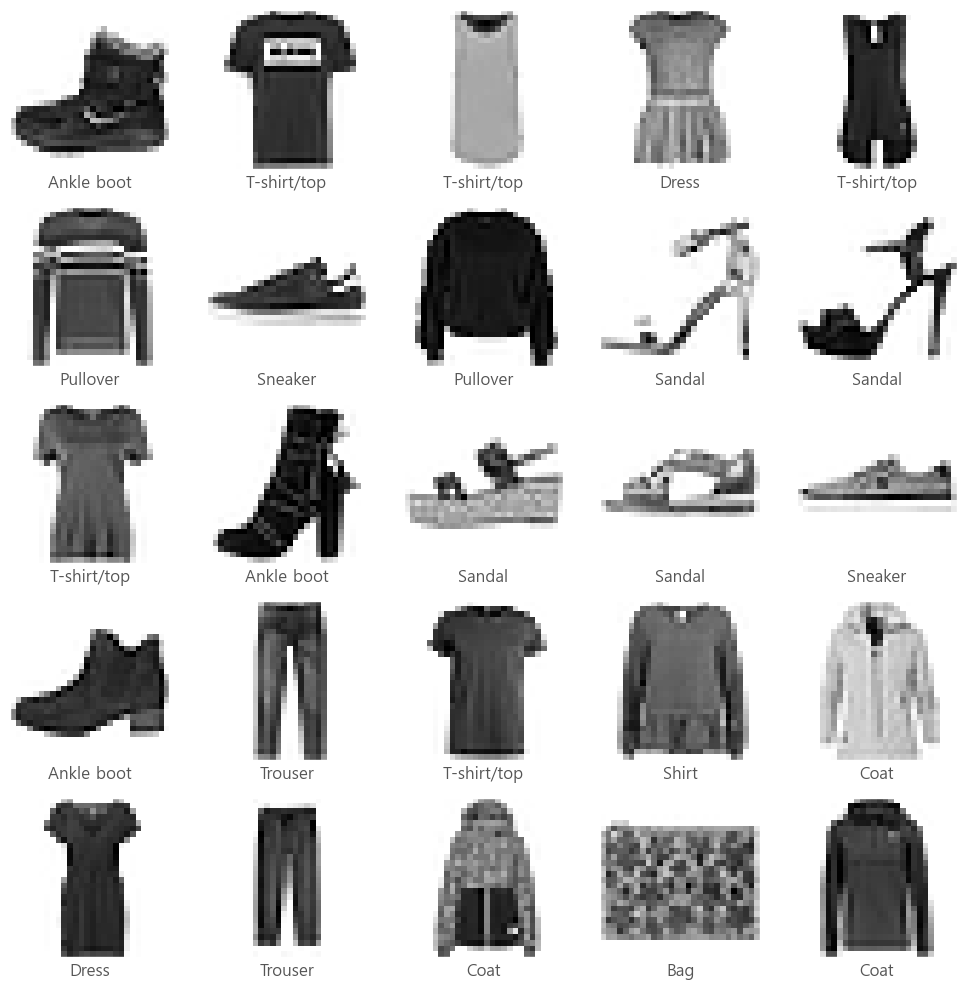

In [3]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_full[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train_full[i]])
plt.tight_layout()
plt.show()

## 4. 전처리 & 검증용 데이터셋 분할

In [4]:
# 정규화 (0~1 사이의 값으로 스케일링)
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# CNN 입력을 위해 채널 차원 추가 (28, 28) -> (28, 28, 1)
x_train_full = np.expand_dims(x_train_full, -1)
x_test = np.expand_dims(x_test, -1)

# 검증용 데이터셋 분할 (학습:검증 = 8:2)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print("학습용 데이터 형태:", x_train.shape)
print("검증용 데이터 형태:", x_val.shape)
print("테스트 데이터 형태:", x_test.shape)


학습용 데이터 형태: (48000, 28, 28, 1)
검증용 데이터 형태: (12000, 28, 28, 1)
테스트 데이터 형태: (10000, 28, 28, 1)


## 5. 모델 설계 및 학습 (CNN)

In [5]:
# CNN(합성곱 신경망) 모델 생성
model = Sequential([
    # 첫 번째 합성곱 블록
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # 두 번째 합성곱 블록
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # 세 번째 합성곱 블록
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # 완전 연결 블록 (MLP 형태)
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,890 (1.67 MB)

 Trainable params: 437,738 (1.67 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
# 콜백 함수 설정
# 1. ModelCheckpoint: 검증 정확도가 가장 높은 모델 저장
checkpoint_cb = ModelCheckpoint("fashion_mnist_best_cnn_model.keras", 
                                save_best_only=True, 
                                monitor='val_accuracy')

# 2. EarlyStopping: 지정된 에포크 동안 검증 손실이 개선되지 않으면 조기 종료
early_stopping_cb = EarlyStopping(patience=10, 
                                  restore_best_weights=True, 
                                  monitor='val_loss')

# 3. ReduceLROnPlateau: 지정된 에포크 동안 검증 손실이 개선되지 않으면 학습률을 감소
reduce_lr_cb = ReduceLROnPlateau(factor=0.5, 
                                 patience=4, 
                                 monitor='val_loss', 
                                 min_lr=1e-6)

# 학습 실행
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)


Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - accuracy: 0.7828 - loss: 0.6305 - val_accuracy: 0.2068 - val_loss: 3.3336 - learning_rate: 0.0010
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.8676 - loss: 0.3670 - val_accuracy: 0.8952 - val_loss: 0.2890 - learning_rate: 0.0010
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.8879 - loss: 0.3105 - val_accuracy: 0.9102 - val_loss: 0.2473 - learning_rate: 0.0010
Epoch 4/100
337/375 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9006 - loss: 0.2752

## 6. 학습 결과 시각화 (loss, accuracy, val_loss, val_accuracy)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy 그래프
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss 그래프
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


## 7. evaluate를 사용한 모델 평가

In [ ]:
# 최상의 모델(EarlyStopping에 의해 자동으로 복원됨 - restore_best_weights=True)로 테스드 데이터 평가
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"\n테스트 손실(Test Loss): {test_loss:.4f}")
print(f"테스트 정확도(Test Accuracy): {test_acc:.4f}")

# 혼동 행렬 및 분류 보고서 (추가 분석)
import seaborn as sns
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\n분류 보고서(Classification Report):")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), 
            annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('혼동 행렬 (Confusion Matrix)')
plt.ylabel('실제 레이블 (True)')
plt.xlabel('예측 레이블 (Predicted)')
plt.show()


## 8. 오분류 데이터 시각화 (실제: Shirt, 예측: T-shirt/top)

In [ ]:
# 실제 레이블 인덱스: Shirt (6)
# 예측 레이블 인덱스: T-shirt/top (0)
true_label_idx = 6
pred_label_idx = 0

# 조건에 맞는 인덱스 추출
misclassified_idx = np.where((y_test == true_label_idx) & (y_pred_classes == pred_label_idx))[0]

print(f"실제 {class_names[true_label_idx]}를 {class_names[pred_label_idx]}으로 잘못 예측한 데이터 수: {len(misclassified_idx)}개")

if len(misclassified_idx) > 0:
    plt.figure(figsize=(12, 12))
    num_images = min(len(misclassified_idx), 25) # 최대 25개까지 시각화
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        idx = misclassified_idx[i]
        plt.imshow(x_test[idx].reshape(28, 28), cmap=plt.cm.binary)
        plt.xlabel(f"True: {class_names[true_label_idx]}\nPred: {class_names[pred_label_idx]}", color="red")
    plt.tight_layout()
    plt.show()
else:
    print("조건에 해당하는 오분류 데이터가 없습니다.")


## 9. 정답 이미지 확인 (T-shirt/top vs Shirt)

In [ ]:
# T-shirt/top (0), Shirt (6)
true_tshirt = 0
true_shirt = 6

# 원본 학습 세트(x_train_full, y_train_full)에서 해당 레이블들의 인덱스 찾기
tshirt_idx = np.where(y_train_full == true_tshirt)[0][:10]
shirt_idx = np.where(y_train_full == true_shirt)[0][:10]

plt.figure(figsize=(15, 6))

# T-shirt/top 이미지 10개 출력
for i, idx in enumerate(tshirt_idx):
    plt.subplot(2, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_full[idx].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(class_names[true_tshirt])

# Shirt 이미지 10개 출력
for i, idx in enumerate(shirt_idx):
    plt.subplot(2, 10, i + 11)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_full[idx].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(class_names[true_shirt])

plt.tight_layout()
plt.show()
